In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transform

Converts data about the DateTime to a more readable format and also extracts information about the day of the week based on the calendar dates to create new feature.

In [2]:
data = pd.read_csv("simpletraffic.csv")

data["DateTime"]= pd.to_datetime(data["DateTime"])

data["Year"] = data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Date"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour
data["DayOfWeek"] = data["DateTime"].dt.dayofweek
data["DayOfWeek"] = data["DayOfWeek"].replace([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

data = data.drop(["ID"], axis=1)

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,DayOfWeek
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DateTime   48120 non-null  datetime64[ns]
 1   Junction   48120 non-null  int64         
 2   Vehicles   48120 non-null  int64         
 3   Year       48120 non-null  int32         
 4   Month      48120 non-null  int32         
 5   Date       48120 non-null  int32         
 6   Hour       48120 non-null  int32         
 7   DayOfWeek  48120 non-null  object        
dtypes: datetime64[ns](1), int32(4), int64(2), object(1)
memory usage: 2.2+ MB


# Exploratory Data Analysis (EDA)

/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 0, 'Date')

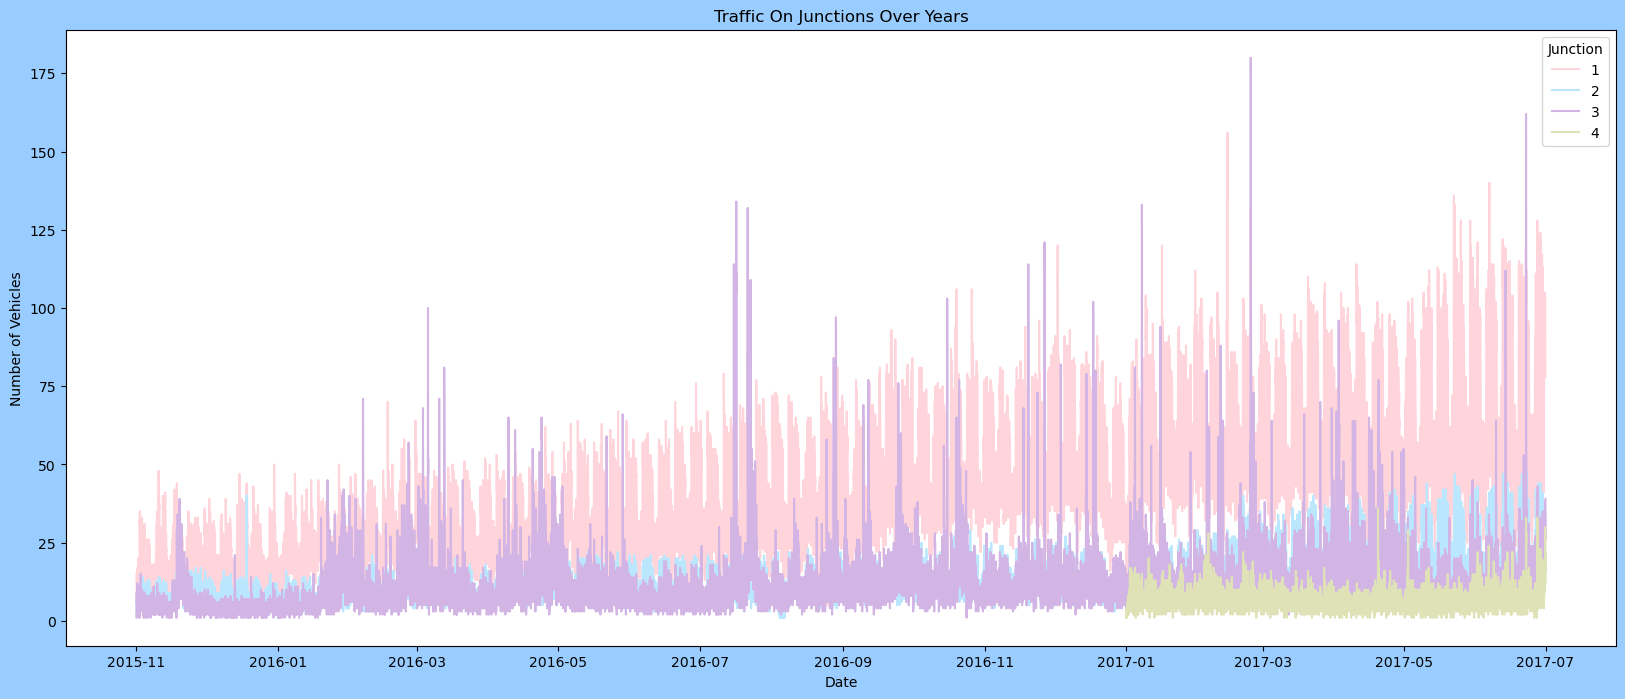

In [4]:
df=data.copy()
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

# Data Preprocessing

In [5]:
def make_hist(junction=1):
    data = df[df['Junction'] == junction]
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data['Vehicles'], kde=True, stat='probability')
    ax.set_title(f'Plot show the distribution of data in junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


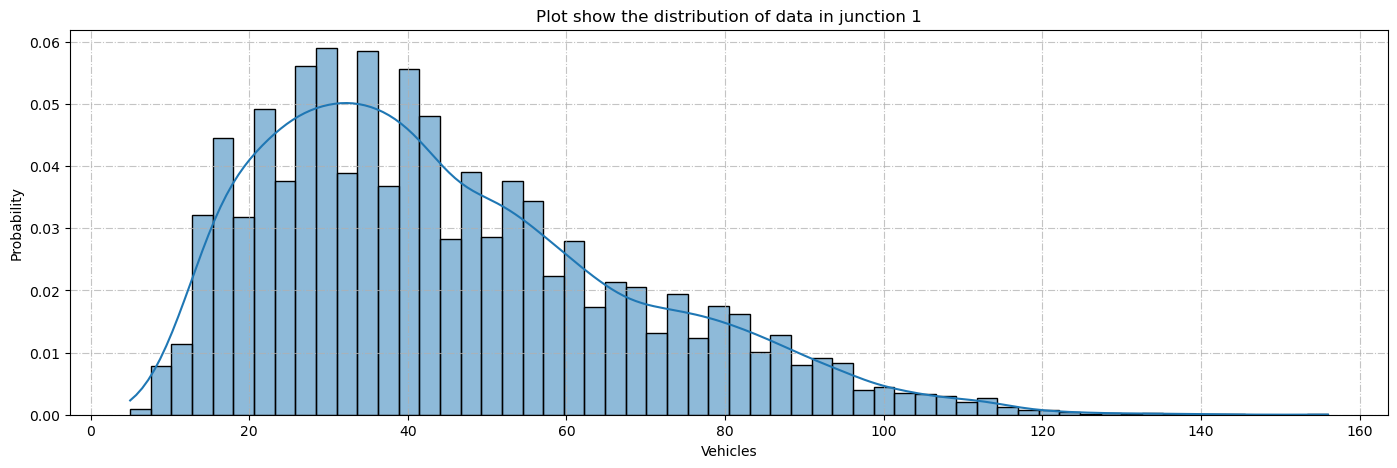

/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


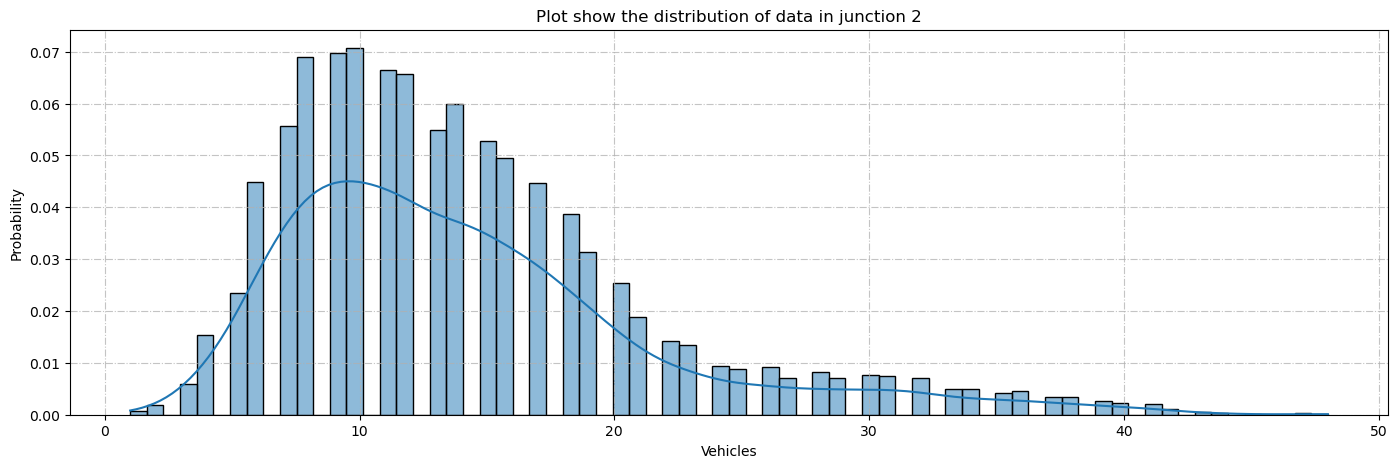

/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


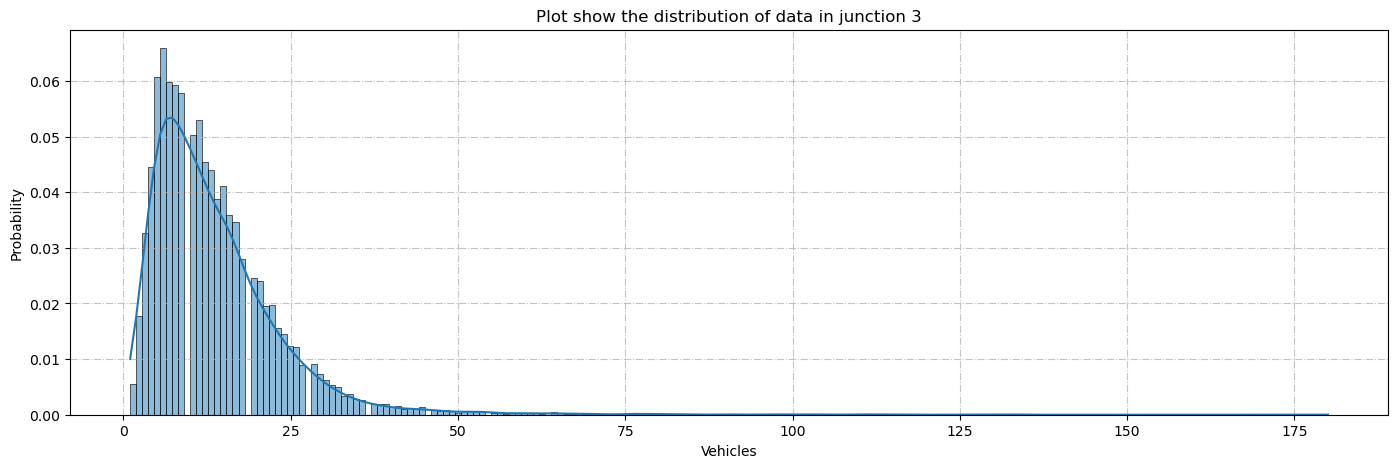

/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tanaynistala/.conda/Traffic/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


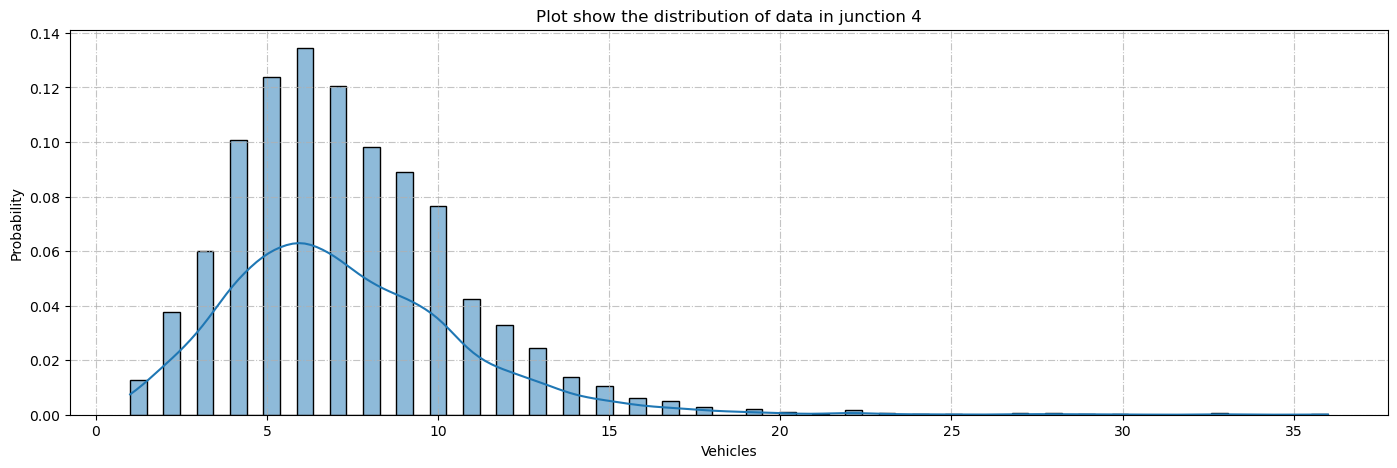

In [6]:
for jn in range(1, 5):
    make_hist(jn)